In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

import json
with open('../api_keys.json', mode = 'r') as f:
    api_keys = json.load(f)
    
# Initialize the client with your API key
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    google_api_key=api_keys['ashishjain1547']
)

In [5]:
from langgraph.graph import StateGraph, END

from langchain_community.document_loaders import WebBaseLoader
from langchain.chat_models import ChatOpenAI
import os

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [6]:
from typing import TypedDict, Annotated
class AgentState(TypedDict):
    nlq: str
    metadata: dict
    refined_query: str
    further_refined_query: str
    feedback: str
    itr_count: int

In [7]:
import re
def extract_triple_quoted_json(response_text):
    # This pattern looks for a JSON object (starting with '{' and ending with '}')
    # enclosed in either triple double-quotes or triple single-quotes.
    pattern = r'(?:\'\'\'|""")\s*(\{.*?\})\s*(?:\'\'\'|""")'
    match = re.search(pattern, response_text, re.DOTALL)
    if match:
        return match.group(1)
    return None

In [14]:
class ReEngineerQuery:
    def __init__(self, model):
        self.model = model
        
        graph = StateGraph(AgentState)


        graph.add_node("refine_query", self.refine_query)
        graph.add_node("evaluate_reengineered_query", self.evaluate_reengineered_query)
        graph.add_node("further_refine_query", self.further_refine_query)

        # --- Edges ---


        graph.set_entry_point("refine_query")
        graph.add_edge("refine_query", "evaluate_reengineered_query")
        graph.add_edge("evaluate_reengineered_query", "further_refine_query")


        graph.add_conditional_edges(
            "further_refine_query", 
            self.should_continue, 
            {"end": END, "refine_query": "refine_query"}
        )

        # Compile the graph and store references
        self.graph = graph.compile()

        

        
    
    def refine_query(self, state):
        META_PROMPT_TO_REENGINEER_NLQ = """
You are an expert SQLite query generator. Based on the natural language query and the provided table metadata,
please reengineer the query to clearly specify:
- The specific table(s) that should be referenced,
- The calculations or aggregations to perform,
- The structure of the final SQL query.

NLQ: {nlq}

Table Metadata:
{metadata}

Reengineered Query:
"""

        # Build the meta-prompt by substituting the NLQ and metadata.
        prompt = META_PROMPT_TO_REENGINEER_NLQ.format(nlq=state.get("nlq", ""), metadata=state.get("metadata", ""))
        # Invoke the LLM with the prompt.
        response = self.model(prompt)
        # Return the refined query.


        return {"refined_query": response.strip(), "itr_count": state.get("itr_count") + 1}
    
    def evaluate_reengineered_query(self, state):
        EVALUATE_REENGINEERED_QUERY = """
You are an expert SQLite engineer grading an NLQ for correctness, completeness and clarity. \
Generate critique and recommendations for the NLQ so it can be easily converted to an SQL. \
Please evaluate the reengineered query below:
{refined_query}
"""

        prompt = EVALUATE_REENGINEERED_QUERY.format(refined_query=state.get("refined_query", ""))
        response = self.model(prompt)
        return {"feedback": response.strip()}
    
    def further_refine_query(self, state):
        REENGINEER_QUERY_POST_FEEDBACK = """
You are an expert SQLite query generator. Based on the natural language query, the provided table metadata and feedback,
please reengineer the query based on the feedback given to clearly specify: 
- The specific table(s) that should be referenced,
- The calculations or aggregations to perform,
- The structure of the final SQL query.

NLQ: {nlq}

Table Metadata:
{metadata}

Feedback:
{feedback}

Reengineered Query:
"""     # Build the meta-prompt by substituting the NLQ and metadata.
        prompt = REENGINEER_QUERY_POST_FEEDBACK.format(nlq=state.get("nlq", ""), metadata=state.get("metadata", ""),
                                                        feedback=state.get("feedback", ""))
        # Invoke the LLM with the prompt.
        response = self.model(prompt)

        print(response)


        return {"further_refined_query": response.strip(), "itr_count": state.get("itr_count") + 1}
    
    def should_continue(self, state):
        CHECK_CONSISTENCY = """
You are an expert database query evaluator. Your task is to evaluate two queries \
if they are consistent and mean the same thing. One query is the last query and the other is the reengineered query. \

Last Query: {refined_query}
Reengineered Query: {further_refined_query}

Is the reengineered query consistent with the last query? 
Return a JSON response with the key 'answer': 'yes' or 'no'."""
        
        prompt = CHECK_CONSISTENCY.format(refined_query=state.get("refined_query", ""), further_refined_query=state.get("further_refined_query", ""))
        response = self.model(prompt)

        #extract json from the response

        print(response)
        
        json_response = "{" + response.split("{")[1].split("}")[0].strip().replace("'", '"') + "}"

        json_response = json.loads(json_response)
        print(json_response)

    
        if json_response['answer'] == "yes":
            return "end"
        return "refine_query"

In [15]:
class MyGeminiChatModel:
    """
    Minimal wrapper that expects a prompt and returns GPT-3.5 Turbo response text.
    """
    def __init__(self, api_key):
        self.client = ChatGoogleGenerativeAI(
        model="gemini-2.0-flash",
        google_api_key = api_key
    )
        
    def bind_tools(self, tools):
        return self  # For compatibility with how TranslatorCriticApp uses .bind_tools

    def __call__(self, prompt: str) -> str:
        response = llm.invoke(prompt)
        return response.content

In [16]:
model = MyGeminiChatModel(api_keys["ashishjain1547"])

In [17]:
app = ReEngineerQuery(model)

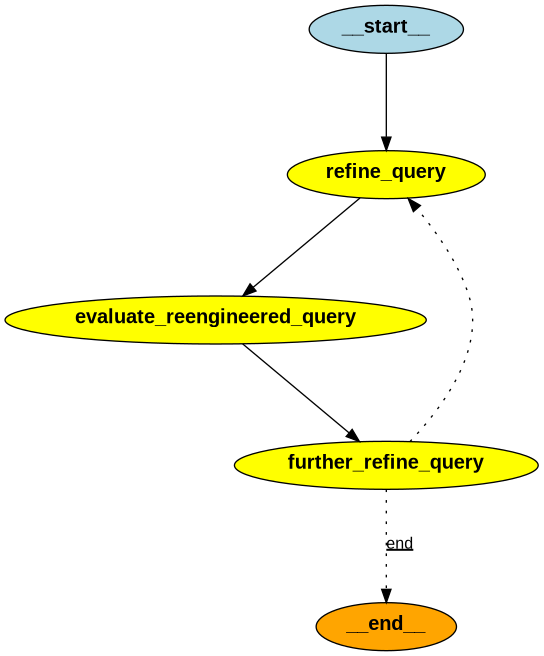

In [18]:
from IPython.display import Image

Image(app.graph.get_graph().draw_png())

In [ ]:
messages = []

with open('tables.json', mode = 'r') as f:
    metadata = json.load(f)

nlq = "Show me the orders from last year."
refined_query = ""
further_refined_query = ""
feedback = ""
itr_count = 0

result = app.graph.invoke({"nlq": nlq, "metadata": metadata, "refined_query": refined_query, "further_refined_query": further_refined_query, "feedback": feedback, "itr_count": itr_count})

```sqlite
SELECT * FROM AB_ORDERS WHERE ORDERYEAR = CAST(STRFTIME('%Y', DATE('now', '-1 year')) AS INTEGER)
```

```json
{
  "answer": "yes"
}
```
{'answer': 'yes'}
